# Logistic Regression

본 코드의 목적은 198개의 문서에 나타나는 단어를 바탕으로 문서의 sentiment를 확률적으로 분류하는 model을 구현하고, 모델의 결과값을 각 문서의 실제 sentiment와 비교하여 정확도를 측정하는 것입니다.  
로지스틱 회귀(Logistic Regression)를 이용하여 이와 같은 목적을 수행합니다.   
본 코드를 통하여 경사법(Gradient Method)을 사용하여 로지스틱 회귀의 매개변수 $\theta$를 구하는 법을 익히고, 이를 실제 데이터에 적용할 수 있습니다.   

*본 코드는 Week2와 똑같은 목적을 가지나, Naive Bayes Classifier에서 Naive 가정(X의 조건부 독립)을 하지 않고 데이터를 학습하는 방법을 익힐 수 있습니다.

### 데이터 입력 및 전처리 과정
주어진 sentimentdataset.mat 파일에는 3종류의 matlab 변수가 저장되어 있습니다.

* bagofword : 198 X 29717 numpy ndarray, 198개의 문서에서 29717개의 단어에 대한 bag of word 저장
* sentiment : 198 X 1 numpy ndarray, 198개의 문서에 대한 positive sentiment/negative sentiment를 각각 0과 1로 저장
* words : 29717 X 1 numpy ndarray, 29717개의 unique 단어 저장

### 실제구현부 
로지스틱 회귀(Logistic Regression)에서는 정의역이 확률인 로짓함수를 데이터와 매개변수 $\theta$ 이루어진 식으로 근사하고, 경사법(Gradient Descent Method)을 이용하여 로지스틱 회귀의 매개변수 $\theta$를 구합니다.

#### 조건부 확률과 로지스틱 함수
P(y|x)는 확률 $\mu(x)$인 이항분포를 따르며 로지스틱 함수 형태라고 가정하면 다음과 같은 조건을 만족합니다.

$$\mu(x) = \frac{1}{1+e^{-\theta T_x}}=P(y=1|x)$$
$$X\theta = log\frac{P(Y|X)}{1-P(Y|X)} \to P(Y|X) = \frac{e^{X\theta}}{1+e^{X \theta}}\space\space\space\color{red}{...\space eq\space(1)}$$

#### 매개변수 θ 찾기
로지스틱 회귀에서는 Maximum Conditional Likelihood Estimator(MCLE)를 이용하여 $\theta$를 구합니다.

$$\hat{\theta} = argmax_\theta P(D|\theta) = argmax_\theta  \prod_{1\leq i\leq n} P(Y_i|X_i;\theta) = argmax_\theta log(\prod_{1\leq i\leq n} P(Y_i|X_i;\theta)) = argmax_\theta  \sum_{1\leq i\leq n}log (P(Y_i|X_i;\theta))$$

여기서 $P(Y_i|X_i;\theta)$가 위와 같이 이항분포를 따른다고 가정하면 $\hat{\theta}$를 다음과 같은 식으로 나타낼 수 있습니다.

$$\hat{\theta} = argmax_\theta  \sum_{1\leq i\leq n} {Y_i X_i \theta - log(1+e^{X_i \theta})}$$

$\theta$의 값을 찾기 위해 위의 식을 \theta_j에 대해 편미분하여, Component별로 미분계수가 0인 지점을 찾습니다.

$$\frac{\partial}{\partial \theta_j} {\sum_{1\leq i\leq N} Y_i X_i \theta - log(1+e^{X_i \theta})} = \sum_{1\leq i\leq N} X_{i,j}(Y_i - P(y=1 | x;\theta)) = 0$$

위의 식에서 $\theta$는 closed form으로 나타나지 않으므로 Gradient Method를 활용하여 $\theta$를 근사해야 합니다.

#### 경사법 (Gradient Method)
종합하면, 찾고자하는 $\hat{\theta}$는 다음과 같은 식으로 정리됩니다.

$$\hat{\theta} = argmax_\theta  \sum_{1\leq i\leq N}log (P(Y_i|X_i;\theta))$$
$$ f(\theta) = \sum_{1\leq i\leq N}log (P(Y_i|X_i;\theta))$$
$$ \frac{\partial f(\theta)}{\partial \theta_j} = \frac{\partial}{\partial \theta_j} \sum_{1\leq i\leq N} log (P(Y_i|X_i;\theta))=\sum_{1\leq i\leq N} X_{i,j}(Y_i - P(y=1 | x;\theta))$$

위의 $\hat{\theta}$는 Argument Maximum으로 Gradient Ascent를 사용하여 구할 수 있습니다. 따라서, $x_{t+1}$를 $x_t+h\frac{f'(x_t)}{|f'(x_t)|}$로 업데이트 합니다. 여기서 매개변수 $\theta$를 반복적으로 업데이트 시켜주기 위해서 다음과 같은 과정을 거칩니다.

\begin{align*} 
\theta_j^{t+1} &\leftarrow   \theta_j^{t} + h\frac{\partial(f(\theta^{t})}{\partial \theta_j^{t}}\\
&= \theta_j^{t}+h{\sum_{1\leq i\leq N} X_{i,j} (Y_i - P(Y=1 | X;\theta^{t}))}\space\space\space \color{red}{...\space eq\space(2)}\\
&= \theta_j^{t}+\frac{h}{C}{\sum_{1\leq i\leq N} X_{i,j} (Y_i - \frac{e^{X_i\theta^{t}}}{1+e^{X_i\theta^{t}}})}
\end{align*}

여기서 상수 C는 중괄호 안의 벡터의 크기로, 이렇게 나눠줌으로써 보정되는 부분을 속력(h)과 방향벡터의 곱으로 나타낼 수 있습니다. 시작위치인 $\theta_j^{0}$는 임의로 설정합니다.

In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Kim Hyemi: khm03080@kaist.ac.kr
'''

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

In [2]:
# Import DATA Set (.mat file)
data = sio.loadmat('sentimentdataset.mat', chars_as_strings=1, matlab_compatible=1)

# sentimentdataset.mat file contains 3 matlab variables
# bagofword: 198 X 29717 double
# sentiment: 198 X 1     double
# word:      29717 X 1  cell -> Only use 2000 cases in this class.

bagofword = data['bagofword'];
sentiment = data['sentiment']; 
sentiment = sentiment.astype(int);
words = data['word'];

# Convert MATLAB Cell into python array
# 낱개로 떨어져있는 단어를 하나의 온전한 단어로 합쳐주는 과정
# ex) [['h', 'o', 'l', 'e', 's']]  -> 'holes'
word = []
for n in range(2000):
    word = word + [str(''.join(letter)) for letter in words[n][0]]

In [3]:
cell = 10; # Training set의 크기를 변화시키는 횟수
replication = 5; # 반복횟수
numTesting = 50; # Testing set의 크기
numWord = 100; # 데이터의 크기 - 모델을 만들 때 사용하는 단어의 개수

trainingAccuracy = np.zeros((replication, 10));
testingAccuracy = np.zeros((replication, 10));
avgTraining = np.zeros((cell, 1));
stdTraining = np.zeros((cell, 1));
avgTesting = np.zeros((cell, 1));
stdTesting = np.zeros((cell, 1));

# Gradient Ascent의 상수 
h = 0.5; # theta가 업데이트 되는 속력
threshold = 0.1; # 업데이트 되는 값이 작은 경우, theta가 local maximum에 수렴할 수 있으므로 threshold를 설정함

for M in range(1,cell+1): # Training set의 변화 횟수만큼 반복
    N = M*10; # N: Training set의 갯수
    for rep in range(replication):
        sample = np.random.permutation(np.arange(198)); #198개 문서를 random shuffle
        
        numFeatures = numWord + 1; # theta의 상수항을 위해 1을 더해줌
        X = np.ones((np.size(sample),numFeatures));
        tempMat = bagofword[sample];
        tempMat = tempMat[:,range(numWord)];
        X[:,range(1,numFeatures)] = tempMat; # 사용하는 단어만 input data X에 대입함
        Y = sentiment[sample];
        
        theta = np.ones((numFeatures,1)); #임의로 설정된 시작위치
        itr = 500; # theta 업데이트 횟수
        
        cntItr = 0;
        for k in range(itr):
            thetanew = np.zeros((numFeatures,1));
            for i in range(numFeatures): # 각 i번째 단어에 대해 아래의 과정을 실행
                temp = 0;
                for j in range(N): # training set중 j번째(shuffle된 문서 기준) 문서에 대해 아래의 과정을 실행
                    Xtheta = 0;
                    Xtheta = np.dot(X[j,:], theta)[0]; # Xtheta = X_i * theta_t
                    temp = temp + X[j,i] * ( Y[j][0] - np.exp(Xtheta) / (1 + np.exp(Xtheta))); # ... eq(2)
                temp = temp * h;
                thetanew[i] = theta[i] + temp; # 업데이트할 theta
            diff = np.sum(np.abs(theta-thetanew));
            if diff/(np.sum(np.abs(theta))) < threshold: #업데이트할 theta가 threshold보다 작으면 업데이트 하지 않음
                break;
            cntItr = cntItr + 1; # 업데이트 횟수
            theta = thetanew;
        
        # probsSentiment : 각 문서가 positive 또는 negative sentiment를 가질 확률
        probsSentiment = np.zeros((198,2));
        for i in range(198):
            Xtheta = np.dot(X[i,:], theta)[0];
            probsSentiment[i,0] = 1 / (1 + np.exp(Xtheta)); # p(y|x)를 로지스틱 함수 형태로 가정하였음 & ... eq(1)
            probsSentiment[i,1] = 1 - 1 / (1 + np.exp(Xtheta)); #p(y|x)를 이항분포로 가정하였음
        
        # MCLE를 통하여 각 문서의 sentiment를 추정함
        estSentiment = np.zeros((198,1));
        for i in range(198):
            if probsSentiment[i,0] > probsSentiment[i,1]:
                estSentiment[i] = 0;
            else:
                estSentiment[i] = 1;
        
        # training accuracy를 측정함
        cntCorrect = 0;
        for i in range(N): # 모든 training set에 대하여 추정값과 실제값을 비교함
            if estSentiment[i] == Y[i]:
                cntCorrect = cntCorrect + 1;
        trainingAccuracy[rep,M-1] = cntCorrect / float(N); #반복횟수에 따른 training set 크기별 training accuracy를 저장함
        
        # testing accuracy를 측정함
        cntCorrect = 0;
        for i in range(N,N+numTesting): # 모든 testing set에 대하여 추정값과 실제값을 비교함
            if estSentiment[i] == Y[i]:
                cntCorrect = cntCorrect + 1;
        testingAccuracy[rep,M-1] = cntCorrect / float(numTesting); #반복횟수에 따른 training set 크기별 testing accuracy를 저장함
    
    # replication된 정확도의 평균값 계산
    avgTraining[M-1] = np.mean(trainingAccuracy[:,M-1]);
    avgTesting[M-1] = np.mean(testingAccuracy[:,M-1]);
    
    # replication된 정확도의 표준편차 계산
    stdTraining[M-1] = np.std(trainingAccuracy[:,M-1]);
    stdTesting[M-1] = np.std(testingAccuracy[:, M-1]);

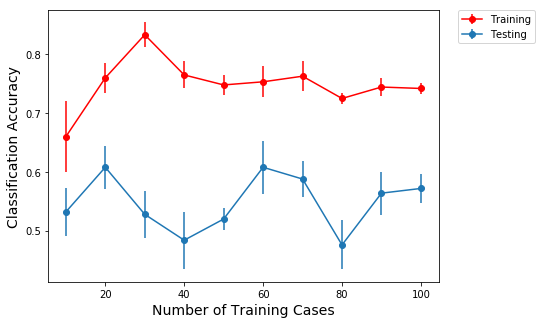

In [4]:
plt.figure(1, figsize = (7,5));
plt.errorbar(np.dot(10,range(1,cell+1)), avgTraining, yerr = stdTraining/np.sqrt(replication), fmt='-o', color='r', label="Training");
plt.errorbar(np.dot(10,range(1,cell+1)), avgTesting, yerr = stdTesting/np.sqrt(replication), fmt='-o', label="Testing");

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of Training Cases', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)

plt.show();

### 결과해석부

위의 그래프는 Training set의 크기에 따른 로지스틱 회귀 모델의 정확도 평균 및 표준편차를 나타냅니다.
위의 결과를 통해 적절한 Training set의 크기는 Training Accuracy가 가장 높은 지점인 30과 40사이에 위치함을 알 수 있습니다.